In [ ]:
import pandas as pd
import geopandas as gpd
from siuba import *

import dask.dataframe as dd

from segment_speed_utils import helpers
from segment_speed_utils.project_vars import SEGMENT_GCS, analysis_date

import intake

In [ ]:
from calitp_data_analysis import geography_utils

# scratch

In [ ]:
# gdf = gpd.read_file('gs://calitp-analytics-data/data-analyses/BRT Infrastructure/District 7/District 7.geojson')

# Add interpolated segments to pipeline

* Additional detail between widely spaced stops is more useful for speed analysis

## Check existing segments

In [3]:
# cat = intake.open_catalog('catalog.yml')

In [4]:
# cat.stop_segments.read()

In [ ]:
path = 'gs://calitp-analytics-data/data-analyses/rt_segment_speeds/segment_options/stop_segments_2024-03-13.parquet'

In [6]:
#  read via geopandas so that geometry stays intact
# segs = gpd.read_parquet(path)

In [7]:
# segs >> head(3)

In [8]:
# segs >> filter(_.shape_array_key == '37bb198ccd3af93e3b7f10bb7602faff') >> count(_.trip_instance_key)

In [9]:
segs.length.quantile(.94)

NameError: name 'segs' is not defined

In [10]:
# segs >> count(_.segment_id) >> arrange(-_.n)

In [11]:
# (segs >> filter(_.segment_id == '5138-7345-1')).explore()

In [12]:
segs_ddf = dd.from_pandas(segs, npartitions=50)

In [13]:
segs_ddf = segs_ddf.assign(length=lambda x: x.geometry.length)

In [14]:
next_sequence_ddf = segs_ddf[['trip_instance_key', 'stop_sequence']].groupby('trip_instance_key').shift(-1)
next_sequence_ddf = next_sequence_ddf.rename(columns={'stop_sequence': 'next_stop_sequence'})

/tmp/ipykernel_1311/231179082.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .shift(1)
  After:  .shift(1, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .shift(1, meta=('x', 'f8'))            for series result
  next_sequence_ddf = segs_ddf[['trip_instance_key', 'stop_sequence']].groupby('trip_instance_key').shift(-1)


In [15]:
#  note this relies on the index
segs_ddf = segs_ddf.join(next_sequence_ddf)

In [16]:
# !mkdir test_segs

In [17]:
segs_ddf[['next_stop_sequence', 'length']].to_parquet('test_segs/')

In [ ]:
# new_cols = segs_ddf.compute()

In [7]:
segs_ddf = dd.read_parquet('test_segs/')

In [9]:
segs_ddf

,next_stop_sequence,length
npartitions=50,,
,float64,float64
,...,...
...,...,...
,...,...
,...,...


In [14]:
#  restart kernel/seperate script

In [10]:
segs = segs.join(segs_ddf.compute())

In [11]:
segs.to_parquet('test_interpolated_segs.parquet')

In [ ]:
segs = gpd.read_parquet('test_interpolated_segs.parquet')

In [ ]:
segs

,trip_instance_key,shape_array_key,stop_id1,stop_sequence,geometry,stop_id2,segment_id,stop_pair,schedule_gtfs_dataset_key,route_id,direction_id,next_stop_sequence,length
0,0000dbb743b258f707687f2dc14ad90f,37bb198ccd3af93e3b7f10bb7602faff,178,0,"LINESTRING (194586.662 -428941.623, 194587.395...",1240,178-1240-1,178__1240,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,108.0,784.47941


## Find BBBR10

In [27]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)

from calitp_data_analysis.tables import tbls
from shared_utils import gtfs_utils_v2

In [24]:
bbb = gtfs_utils_v2.schedule_daily_feed_to_gtfs_dataset_name('2024-03-13') >> filter(_.name.str.contains('Big Blue'))

In [25]:
bbb

,key,date,feed_key,feed_timezone,base64_url,gtfs_dataset_key,gtfs_dataset_name,type,name,regional_feed_type
219,c35ae2a7cb1f9ad2cf0a5bce84ccf298,2024-03-13,4f9888472a8dad0f66bdbbd002312789,America/Los_Angeles,aHR0cDovL2d0ZnMuYmlnYmx1ZWJ1cy5jb20vY3VycmVudC...,efbbd5293be71f7a5de0cf82b59febe1,Big Blue Bus Schedule,schedule,Big Blue Bus Schedule,None


In [40]:
bbbr10 = (tbls.mart_gtfs.fct_scheduled_trips()
 >> filter(_.gtfs_dataset_key.isin(bbb.gtfs_dataset_key),
          _.route_short_name.str.contains('R10'),
          _.service_date == '2024-03-13')
) >> collect()

In [41]:
bbbr10

,key,trip_instance_key,feed_timezone,base64_url,name,regional_feed_type,gtfs_dataset_key,service_date,feed_key,service_id,...,trip_last_arrival_datetime_pacific,trip_start_date_local_tz,trip_first_departure_datetime_local_tz,trip_last_arrival_datetime_local_tz,trip_first_start_pickup_drop_off_window_date_pacific,trip_first_start_pickup_drop_off_window_datetime_pacific,trip_last_end_pickup_drop_off_window_pacific,trip_first_start_pickup_drop_off_window_date_local_tz,trip_first_start_pickup_drop_off_window_datetime_local_tz,trip_last_end_pickup_drop_off_window_datetime_local_tz
0,90db8c72792ec17cbfbcea25c4755ee1,d98e5cc1fb62e6e5ed0030934ef8a396,America/Los_Angeles,aHR0cDovL2d0ZnMuYmlnYmx1ZWJ1cy5jb20vY3VycmVudC...,Big Blue Bus Schedule,None,efbbd5293be71f7a5de0cf82b59febe1,2024-03-13,4f9888472a8dad0f66bdbbd002312789,10,...,2024-03-13 06:48:33,2024-03-13,2024-03-13 06:00:00,2024-03-13 06:48:33,None,None,None,None,None,None
1,3fe37ab5b4a46d3be38536059411b341,3505bf6a20e8d29e83e545784a421bc7,America/Los_Angeles,aHR0cDovL2d0ZnMuYmlnYmx1ZWJ1cy5jb20vY3VycmVudC...,Big Blue Bus Schedule,None,efbbd5293be71f7a5de0cf82b59febe1,2024-03-13,4f9888472a8dad0f66bdbbd002312789,10,...,2024-03-13 08:09:24,2024-03-13,2024-03-13 07:00:00,2024-03-13 08:09:24,None,None,None,None,None,None
2,89f1fb4c504b72d70209787272cdf30e,c3577c96a714df975f5525b246987e41,America/Los_Angeles,aHR0cDovL2d0ZnMuYmlnYmx1ZWJ1cy5jb20vY3VycmVudC...,Big Blue Bus Schedule,None,efbbd5293be71f7a5de0cf82b59febe1,2024-03-13,4f9888472a8dad0f66bdbbd002312789,10,...,2024-03-13 09:22:20,2024-03-13,2024-03-13 08:04:00,2024-03-13 09:22:20,None,None,None,None,None,None
3,f0853c83ae28356bf98795ffd26bf2b6,f1866ab43b90dd43adb557fe527177d2,America/Los_Angeles,aHR0cDovL2d0ZnMuYmlnYmx1ZWJ1cy5jb20vY3VycmVudC...,Big Blue Bus Schedule,None,efbbd5293be71f7a5de0cf82b59febe1,2024-03-13,4f9888472a8dad0f66bdbbd002312789,10,...,2024-03-13 16:35:00,2024-03-13,2024-03-13 15:35:00,2024-03-13 16:35:00,None,None,None,None,None,None
4,9688636df1f105e304939f80869ff475,8a452661390b69cd00fdcde92066cc4a,America/Los_Angeles,aHR0cDovL2d0ZnMuYmlnYmx1ZWJ1cy5jb20vY3VycmVudC...,Big Blue Bus Schedule,None,efbbd5293be71f7a5de0cf82b59febe1,2024-03-13,4f9888472a8dad0f66bdbbd002312789,10,...,2024-03-13 18:29:00,2024-03-13,2024-03-13 17:05:00,2024-03-13 18:29:00,None,None,None,None,None,None
5,ca6cc33527b7e8079279008ed55b09af,5d3dc572ce27ef902024f6f135cf59c2,America/Los_Angeles,aHR0cDovL2d0ZnMuYmlnYmx1ZWJ1cy5jb20vY3VycmVudC...,Big Blue Bus Schedule,None,efbbd5293be71f7a5de0cf82b59febe1,2024-03-13,4f9888472a8dad0f66bdbbd002312789,10,...,2024-03-13 19:15:00,2024-03-13,2024-03-13 18:05:00,2024-03-13 19:15:00,None,None,None,None,None,None


## Work out function

In [18]:
import shapely

In [19]:
shapely.__version__

'2.0.1'

In [20]:
test = segs >> filter(_.trip_instance_key == '3505bf6a20e8d29e83e545784a421bc7')

In [21]:
long = test >> filter(_.stop_sequence == 18)

In [22]:
geom = long.geometry.iloc[0]

In [23]:
geom.length

17696.81706739369

In [24]:
km_segs = geom.length // 1000
km_segs

17.0

In [25]:
def split_distance(geom, dist=1000):
    '''
    geom: shapely.LineString
    
    returns a shapely.MultiLineString split every dist (meters)
    '''
    
    split_segs = geom.length // dist
    substrings = []
    for i in range(0, int(split_segs)):
        substrings += [shapely.ops.substring(geom, i * dist, (i+1) * dist)]
    substrings += [shapely.ops.substring(geom, split_segs * dist, geom.length)]
    new_geom = shapely.MultiLineString(substrings)
    
    return new_geom

In [26]:
new_geom = split_distance(geom)

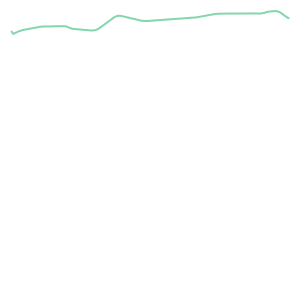

In [27]:
geom

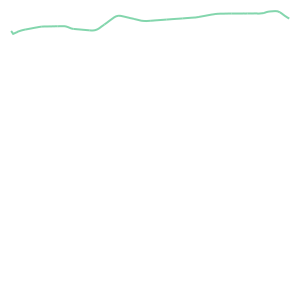

In [28]:
new_geom

In [29]:
# geom.wkt

In [30]:
# new_geom.wkt

In [31]:
long.geometry = [new_geom]

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [32]:
exploded = long.explode()

/tmp/ipykernel_361/1845589243.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded = long.explode()


In [34]:
#  note order remains from list order passed to MultiLineString constructor
# exploded

In [35]:
import numpy as np

In [36]:
def process_exploded(gdf):
    '''
    update required cols in exploded gdf
    
    stop_sequence: add decimal proportional to segment distance
    segment_id: postfix _(int) per segment to maintain uniqueness
    '''
    gdf.length = gdf.geometry.apply(lambda x: x.length)
    
    min_stop = int(gdf.stop_sequence.min())
    next_stop = int(gdf.next_stop_sequence.max())
    stop_seq_chg = gdf.next_stop_sequence.max() - min_stop
    
    #  increment stop sequence proportional to distance traveled 
    seq_per_km = stop_seq_chg / gdf.length.sum() 
    seq_changes = gdf.length * seq_per_km
    stop_sequences_scaled = np.flip(next_stop - np.flip(seq_changes).cumsum())
    
    gdf.stop_sequence = stop_sequences_scaled
    
    #  postfix to segment_id so that it remains unique
    postfixes = np.arange(0, gdf.shape[0]).astype(str)
    underscores = np.full(gdf.shape[0], '_')
    postfixes = np.char.add(underscores, postfixes)
    gdf.segment_id = gdf.segment_id + postfixes
    
    return(gdf)

In [37]:
processed = process_exploded(exploded)

In [38]:
from shared_utils.rt_utils import arrowize_segment

In [39]:
arrowize_segment?

Signature: arrowize_segment(line_geometry, buffer_distance: int = 20)
Docstring:
Given a linestring segment from a gtfs shape,
buffer and clip to show direction of progression
File:      ~/data-analyses/_shared_utils/shared_utils/rt_utils.py
Type:      function

In [40]:
processed.geometry = processed.geometry.apply(lambda x: arrowize_segment(x))

In [42]:
# processed

In [44]:
# processed.explore()

## Abstracting -- drop long geoms from overall, process as array of gdfs, merge?

In [45]:
shorts = (segs[segs['length'] < 1000]).copy()

In [46]:
longs = (segs[segs['length'] > 1000]).copy()

In [47]:
longs.shape

(177840, 13)

In [34]:
test_longs = longs.iloc[:1000,:]

In [35]:
test_longs.head(3)

,trip_instance_key,shape_array_key,stop_id1,stop_sequence,geometry,stop_id2,segment_id,stop_pair,schedule_gtfs_dataset_key,route_id,direction_id,next_stop_sequence,length
22,0000dbb743b258f707687f2dc14ad90f,37bb198ccd3af93e3b7f10bb7602faff,819,1672,"LINESTRING (195533.932 -435807.899, 195532.071...",2304,819-2304-1,819__2304,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,1959.0,1734.469963
78,09e32488392ad4c1684b0108f3bba8b3,37bb198ccd3af93e3b7f10bb7602faff,819,1532,"LINESTRING (195533.932 -435807.899, 195532.071...",2304,819-2304-1,819__2304,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,1767.0,1734.469963
134,0aaeb33101f4ac9ebb7851388c355825,37bb198ccd3af93e3b7f10bb7602faff,819,1672,"LINESTRING (195533.932 -435807.899, 195532.071...",2304,819-2304-1,819__2304,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,1959.0,1734.469963


### Rowwise apply and accumulate?

In [52]:
interpolated_longs = []

def interpolate_segments(row):
    '''
    
    '''
    global interpolated_longs
    new_geom = split_distance(row.geometry)

    row.geometry = new_geom
    #  back to gdf to use .explode()
    row = (gpd.GeoDataFrame(row)
           .transpose()
           .set_geometry('geometry')
           .set_crs(geography_utils.CA_NAD83Albers)
          )
    exploded = gpd.GeoDataFrame.explode(row, column='geometry', index_parts=False)
    # return exploded
    processed = process_exploded(exploded)
    
    interpolated_longs += [processed]
    return

In [56]:
# test1 = test_longs.head(1)

# x = test1.apply(interpolate_segments, axis=1)

# gdf = pd.concat(interpolated_longs)

# #  can't split at endpoints (no next stop seq, must calculate upstream instead of shift!)
# #  drop for now to test
# test_longs = test_longs >> filter(-_.next_stop_sequence.isna())

# %%timeit

# interpolated_longs = []

# _ = test_longs.apply(interpolate_segments, axis=1)

# (14 * 177) / 60 #  41min to interpolate all -- not entirely ideal

# interpolated.shape

# (interpolated >> distinct(_.segment_id, _keep_all=True)).shape

## once per geom, join

##  much of this compute is going to the same segments... better to do once and join to trips?

* compute/join on `shape_array_key, segment_id`
* accumulate geoms only in dict; lookup/replace geoms in full df, then use `gdf.explode()`

In [139]:
longs.head(1)

,trip_instance_key,shape_array_key,stop_id1,stop_sequence,geometry,stop_id2,segment_id,stop_pair,schedule_gtfs_dataset_key,route_id,direction_id,next_stop_sequence,length
22,0000dbb743b258f707687f2dc14ad90f,37bb198ccd3af93e3b7f10bb7602faff,819,1672,"LINESTRING (195533.932 -435807.899, 195532.071...",2304,819-2304-1,819__2304,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,1959.0,1734.469963


In [49]:
to_interpolate = (longs >> distinct(_.shape_array_key, _.segment_id, _keep_all=True)
                     >> filter(-_.next_stop_sequence.isna()) #  fix upstream (include final next seq...)
                 )

In [54]:
to_interpolate >> head(1)

,trip_instance_key,shape_array_key,stop_id1,stop_sequence,geometry,stop_id2,segment_id,stop_pair,schedule_gtfs_dataset_key,route_id,direction_id,next_stop_sequence,length
0,0000dbb743b258f707687f2dc14ad90f,37bb198ccd3af93e3b7f10bb7602faff,819,1672,"LINESTRING (195533.932 -435807.899, 195532.071...",2304,819-2304-1,819__2304,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,1959.0,1734.469963


In [53]:
%%time

interpolated_longs = []

_ = to_interpolate.apply(interpolate_segments, axis=1)

CPU times: user 3min 51s, sys: 5.01 s, total: 3min 56s
Wall time: 3min 58s


In [55]:
interpolated = pd.concat(interpolated_longs)
interpolated.geometry = interpolated.geometry.apply(lambda x: arrowize_segment(x))

In [59]:
interpolated.shape

(56538, 13)

In [62]:
# (interpolated.iloc[:10000,:]).explore()